In [1]:
import polars as pl
import os
import matplotlib.pyplot as plt
import pywt
import numpy as np
import requests

In [2]:
data = "seismic_data/data"
# get all files in the data directory and its subdirectories

files = []
for root, dirs, file in os.walk(data):
    for f in file:
        files.append(os.path.join(root, f))

# read all files into a single DataFrame
files = sorted(files)

In [3]:
files

['seismic_data/data/test/mars/0001.csv',
 'seismic_data/data/test/mars/0002.csv',
 'seismic_data/data/test/mars/0007.csv',
 'seismic_data/data/test/mars/0011.csv',
 'seismic_data/data/test/mars/0017.csv',
 'seismic_data/data/test/mars/0032.csv',
 'seismic_data/data/test/mars/0033.csv',
 'seismic_data/data/test/mars/0034.csv',
 'seismic_data/data/test/mars/0041.csv',
 'seismic_data/data/test/moon/12_b_00006.csv',
 'seismic_data/data/test/moon/12_b_00007.csv',
 'seismic_data/data/test/moon/12_b_00014.csv',
 'seismic_data/data/test/moon/12_b_00016.csv',
 'seismic_data/data/test/moon/12_b_00018.csv',
 'seismic_data/data/test/moon/12_b_00020.csv',
 'seismic_data/data/test/moon/12_b_00021.csv',
 'seismic_data/data/test/moon/12_b_00026.csv',
 'seismic_data/data/test/moon/12_b_00027.csv',
 'seismic_data/data/test/moon/12_b_00028.csv',
 'seismic_data/data/test/moon/12_b_00029.csv',
 'seismic_data/data/test/moon/12_b_00031.csv',
 'seismic_data/data/test/moon/12_b_00035.csv',
 'seismic_data/data/

In [4]:
sample = pl.read_csv(files[107])

In [5]:
sample

mq,time_rel,velocity,velocity_processed
i64,f64,f64,f64
0,0.0,-6.1533e-14,0.0
0,0.150943,-7.7013e-14,0.0
0,0.301887,-8.3962e-14,0.0
0,0.45283,-8.0962e-14,0.0
0,0.603774,-7.0976e-14,0.0
…,…,…,…
1,86401.509434,-1.4727e-14,1.5595e-15
1,86401.660377,-1.9561e-14,-6.3999e-15
1,86401.811321,-2.2403e-14,7.6492e-15


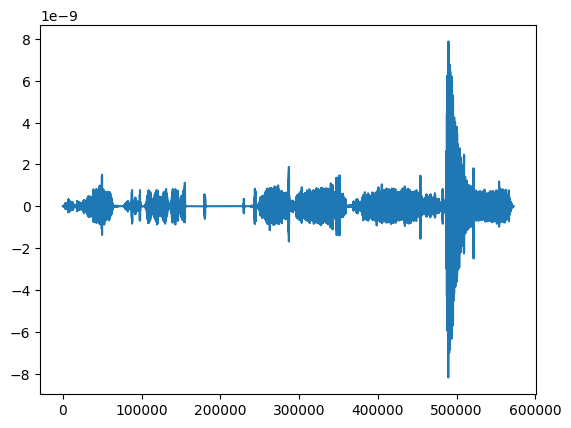

In [6]:
plt.plot(sample["velocity"])

In [7]:
def denoising(data, id):
    data = data.to_list()
    data = [[x] for x in data]
    response = requests.post(
        "https://ai4eps-deepdenoiser.hf.space/predict",
        json={"vec": [data], "timestamp": ["0"], "id": [id]},
    )
    print(response)
    denoised = [x[0] for x in response.json()["vec"][0]]
    return denoised

In [8]:
denoised = denoising(sample["velocity"], files[107])

<Response [200]>


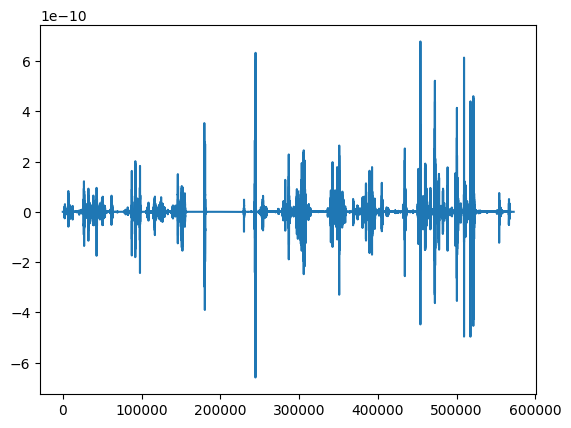

In [9]:
plt.plot(denoised)

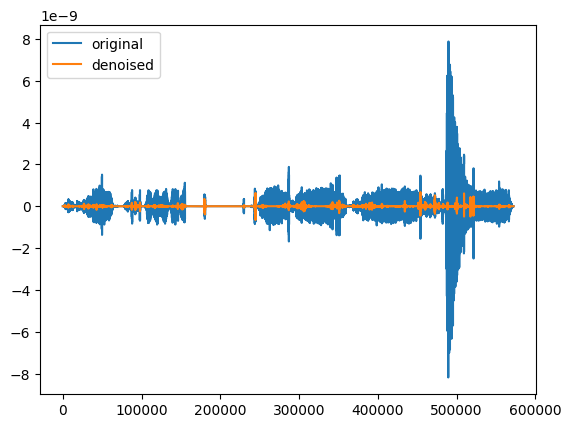

In [10]:
plt.plot(sample["velocity"], label="original")
plt.plot(denoised, label="denoised")
plt.legend()
plt.show()

In [11]:
for file in files:
    df = pl.read_csv(file)
    df = df.with_columns(df["velocity"].cast(pl.Float64).alias("velocity"))
    # denoised = denoising(df["velocity"], file)
    # df = df.with_columns(pl.Series(denoised, dtype=pl.Float64).alias("velocity_processed"))
    mq = df["mq"].to_numpy()
    idx = np.where(mq == 1)[0][1:]
    mq[idx] = 0
    df = df.with_columns(pl.Series(mq).alias("mq_start"))
    df = df.select(sorted(df.columns))
    df.write_csv(file)